# **Fantasy Basketball League: Predicting Game Result**
Ye Ri Park 3035712080, Pranay Sandeep Periwal 3035664697, Yashvardhan Srivastava 3035664659

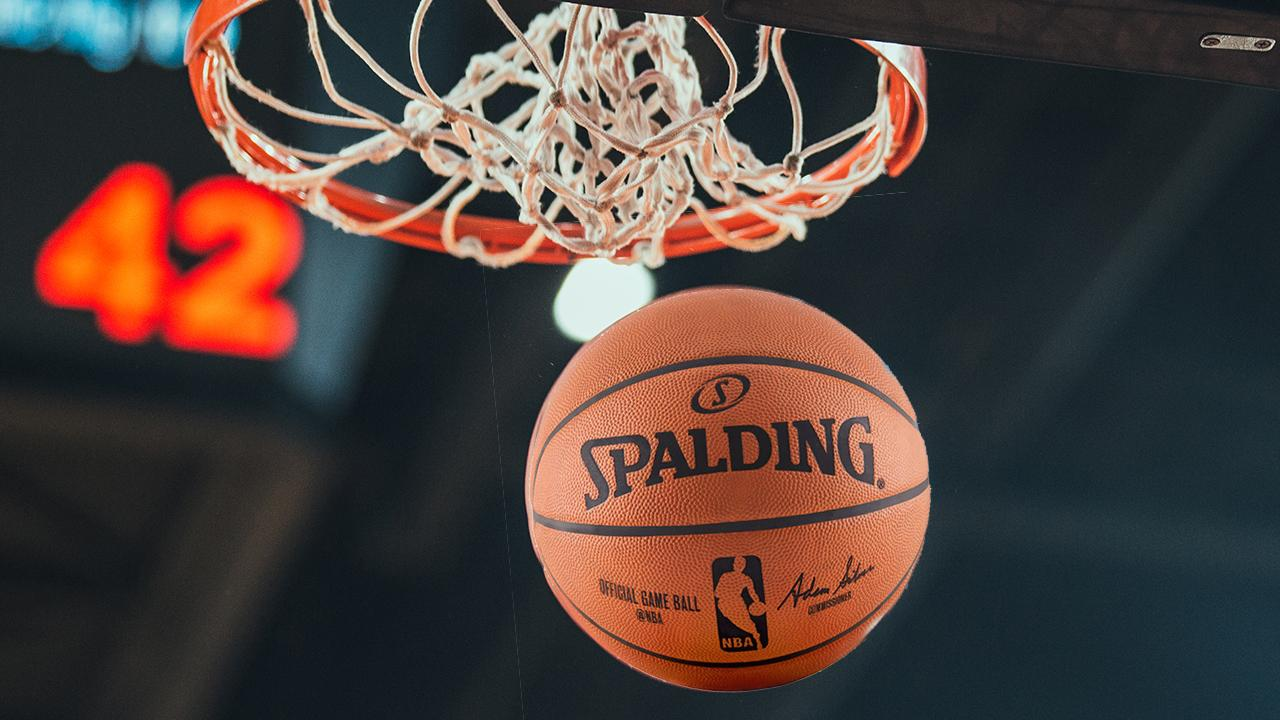





Basketball fans love to discuss and guess which team consisting of their favourite players will win. Be it putting all time greats head to head or thinking about their abilities as the GM of a franchise, these discussions have never had conclusive answers. With our proposed AI application, we aimed to use statistics of past performances of players to predict the outcome of a game between any two teams with the players being chosen by users.

We also extended our model and applied it to a randomly generated fantasy basketball league (including the user’s team) to let them see how they would fare against the various franchises in the league. Using the NBA Playoff elimination style, we let the users see how far they make into the final tournament.

At the end, we managed to create an application with relatively high accuracy that satisfyingly predicts the outcome of games depending on the players chosen.



In [ ]:
!pip3 list -v

Package                       Version        Location                               Installer
----------------------------- -------------- -------------------------------------- ---------
absl-py                       0.12.0         /usr/local/lib/python3.7/dist-packages pip      
alabaster                     0.7.12         /usr/local/lib/python3.7/dist-packages pip      
albumentations                0.1.12         /usr/local/lib/python3.7/dist-packages pip      
altair                        4.1.0          /usr/local/lib/python3.7/dist-packages pip      
appdirs                       1.4.4          /usr/local/lib/python3.7/dist-packages pip      
argon2-cffi                   20.1.0         /usr/local/lib/python3.7/dist-packages pip      
astor                         0.8.1          /usr/local/lib/python3.7/dist-packages pip      
astropy                       4.2.1          /usr/local/lib/python3.7/dist-packages pip      
astunparse                    1.6.3          /usr/local/lib/

# Links for the Application

[Data Formatting for the Simulation](./simulationDataFormatted.ipynb)

[Simulation of Fantasy Basketball League](./simulation.ipynb)


# 1. Loading Dataset

- dfs[0] contains player statistics (input of the model)
  - df contains player stats for each match
- dfs[1] contains game outcomes (output of the model)
  - df_result contains match outcomes


In [ ]:
""" Prepare Notebook for Google Colab """
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/COMP3359/AI_Project/data"

Mounted at /content/drive


In [ ]:
""" Getting the Datasets into Dataframes """

import glob
import pandas as pd

#get data file names
filenames = glob.glob(data_dir + "/*.csv")

#dfs with all csv files in pandas
dfs = [pd.read_csv(filename) for filename in filenames]

In [ ]:
""" Storing the Output Dataframe into 'df_result' """

#df_result contains the win loss outcome of each game 
df_result = dfs[1][['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS', 'SEASON']]
display(df_result)

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,SEASON
0,22000645,1610612748,1610612754,0,2020
1,22000016,1610612745,1610612760,0,2020
2,22000646,1610612743,1610612740,0,2020
3,22000167,1610612738,1610612753,1,2020
4,22000647,1610612751,1610612764,1,2020
...,...,...,...,...,...
24190,11400007,1610612737,1610612740,1,2014
24191,11400004,1610612741,1610612764,0,2014
24192,11400005,1610612747,1610612743,1,2014
24193,11400002,1610612761,1610612758,1,2014


In [ ]:
""" Storing the Input Dataframe into 'df' """

# copying player match statistics from 'games.csv' to df
# df contains statistics for each player of both teams for each match
df = dfs[0].copy()
display(df)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22000645,1610612754,IND,Indiana,203200,Justin Holiday,F,NaN,41:45,5.0,11.0,0.455,5.0,11.0,0.455,0.0,0.0,0.000,0.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,15.0,8.0
1,22000645,1610612754,IND,Indiana,1627734,Domantas Sabonis,F,NaN,35:06,5.0,13.0,0.385,0.0,2.0,0.000,7.0,7.0,1.000,2.0,9.0,11.0,1.0,3.0,0.0,5.0,6.0,17.0,-2.0
2,22000645,1610612754,IND,Indiana,1626167,Myles Turner,C,NaN,29:58,4.0,8.0,0.500,3.0,5.0,0.600,5.0,6.0,0.833,1.0,5.0,6.0,1.0,0.0,5.0,2.0,3.0,16.0,6.0
3,22000645,1610612754,IND,Indiana,1627747,Caris LeVert,G,NaN,34:42,5.0,18.0,0.278,2.0,6.0,0.333,1.0,1.0,1.000,0.0,3.0,3.0,3.0,1.0,0.0,0.0,1.0,13.0,1.0
4,22000645,1610612754,IND,Indiana,1627763,Malcolm Brogdon,G,NaN,40:35,4.0,17.0,0.235,3.0,11.0,0.273,1.0,2.0,0.500,3.0,3.0,6.0,10.0,1.0,0.0,2.0,1.0,12.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602762,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,19,4.0,9.0,0.444,3.0,6.0,0.500,6.0,7.0,0.857,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
602763,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,23,7.0,11.0,0.636,0.0,0.0,0.000,4.0,4.0,1.000,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
602764,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,15,3.0,7.0,0.429,0.0,0.0,0.000,0.0,0.0,0.000,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
602765,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,19,1.0,1.0,1.000,0.0,0.0,0.000,0.0,2.0,0.000,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


# 2. Data Exploration

### Correlations

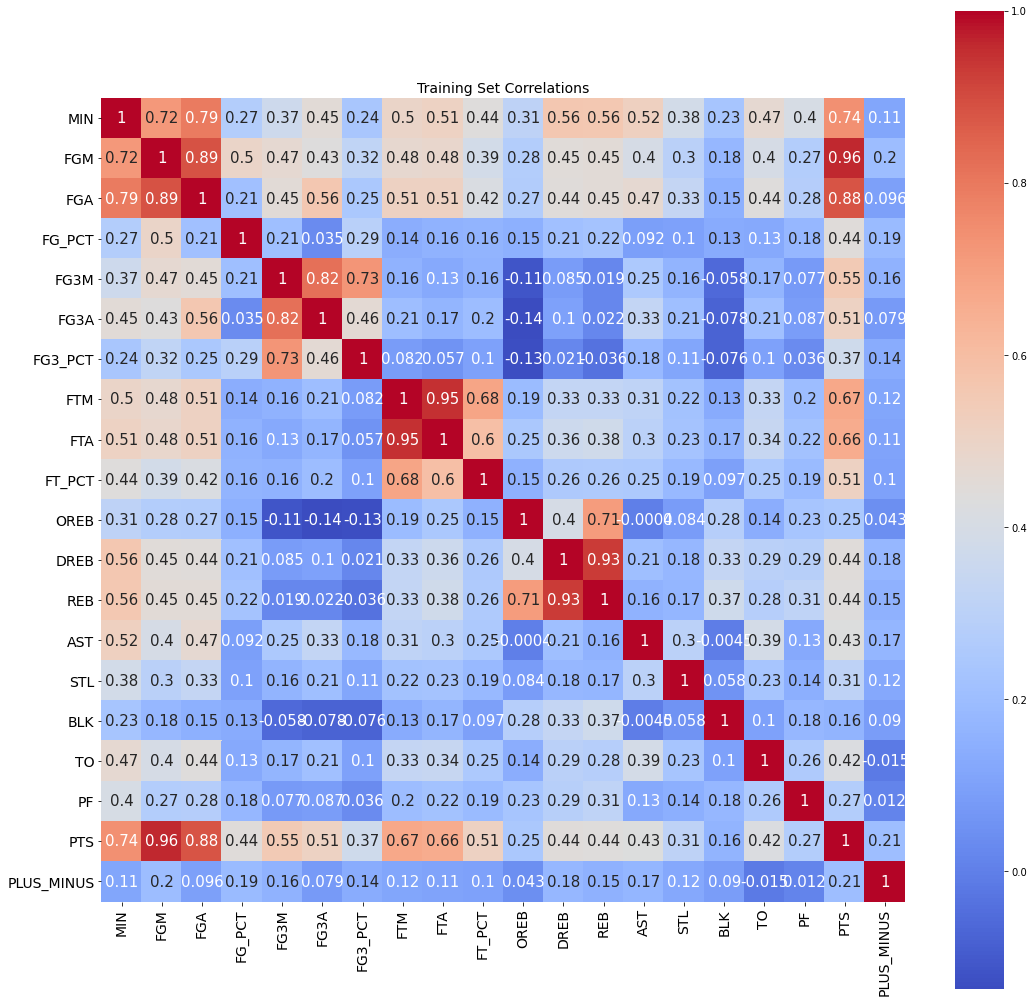

In [ ]:
""" Displaying Correlations into a Heatmap """

import matplotlib.pyplot as plt
import seaborn as sns
df_heatmap = df.copy()
df_heatmap.dropna(subset=["PLUS_MINUS"],inplace=True)
df_heatmap['MIN'] = df_heatmap['MIN'].apply(lambda x: int(str(x)[:str(x).index(':')])*60+int(str(x)[str(x).index(':')+1:]))
fig, axs = plt.subplots(nrows=1, figsize=(18, 18))
sns.heatmap(df_heatmap.drop(['GAME_ID','TEAM_ID','PLAYER_ID'], axis=1).corr(), ax=axs, annot=True, square=True, cmap='coolwarm', annot_kws={'size': 15})
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)    
axs.set_title('Training Set Correlations', size=14)
plt.show()

### Comparison Graphs

In [ ]:
""" Creating a Dataframe for the Comparison Graphs """

df_PTS = []
df_FG_PCT = []
df_FG3_PCT = []
df_FT_PCT = []
df_REB = []
df_AST = []
df_STL = []
df_BLK = []
df_START_POSITION_G = []
df_START_POSITION_F = []
df_START_POSITION_C = []
df_START_POSITION_NO = []

df_result_explore = df_result.copy()
for i in df_result['GAME_ID']:
  df_gameids = df.loc[df['GAME_ID'] == i]
  df_gameids = df_gameids.iloc[0:5]
  df_PTS.append(df_gameids['PTS'].mean())
  df_FG_PCT.append(df_gameids['FG_PCT'].mean())
  df_FG3_PCT.append(df_gameids['FG3_PCT'].mean())
  df_FT_PCT.append(df_gameids['FT_PCT'].mean())
  df_REB.append(df_gameids['REB'].mean())
  df_AST.append(df_gameids['AST'].mean())
  df_STL.append(df_gameids['STL'].mean())
  df_BLK.append(df_gameids['BLK'].mean())
  df_START_POSITION_G.append(len(df_gameids[df_gameids['START_POSITION']=='G']))
  df_START_POSITION_F.append(len(df_gameids[df_gameids['START_POSITION']=='F']))
  df_START_POSITION_C.append(len(df_gameids[df_gameids['START_POSITION']=='C']))
  df_START_POSITION_NO.append(len(df_gameids[df_gameids['START_POSITION']=='NO']))

df_result_explore['PTS']=df_PTS
df_result_explore['FG_PCT']=df_FG_PCT
df_result_explore['FG3_PCT']=df_FG3_PCT
df_result_explore['FT_PCT']=df_FT_PCT
df_result_explore['REB']=df_REB
df_result_explore['AST']=df_AST
df_result_explore['STL']=df_STL
df_result_explore['BLK']=df_BLK
df_result_explore['START_POSITION_G']=df_START_POSITION_G
df_result_explore['START_POSITION_F']=df_START_POSITION_F
df_result_explore['START_POSITION_C']=df_START_POSITION_C
df_result_explore['START_POSITION_NO']=df_START_POSITION_NO

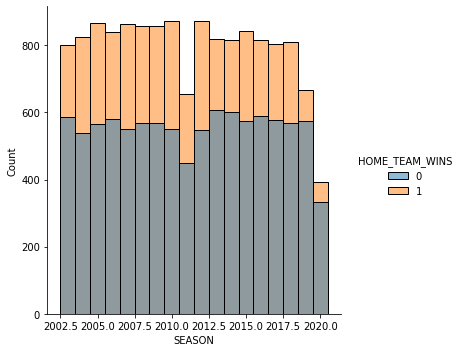

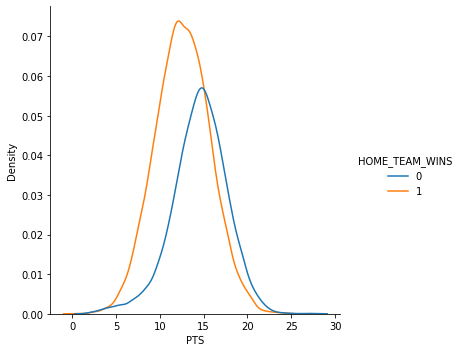

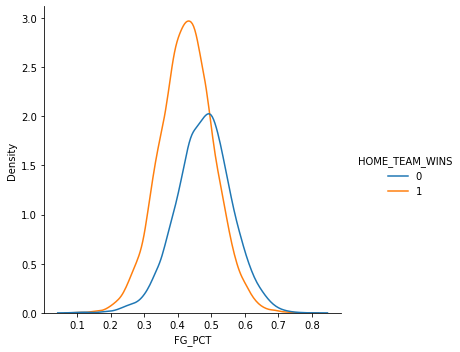

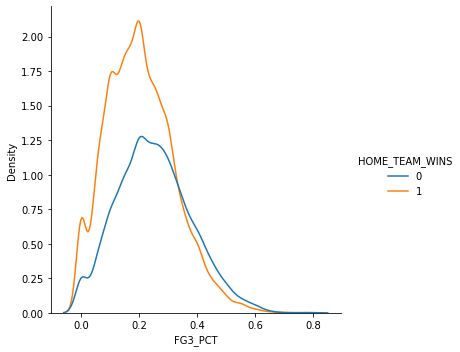

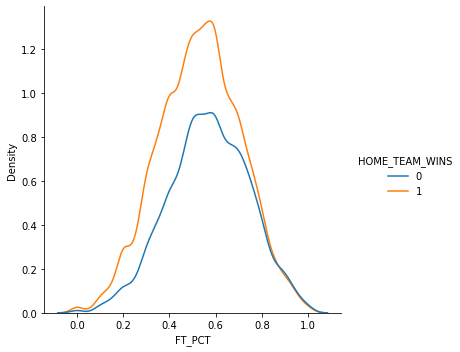

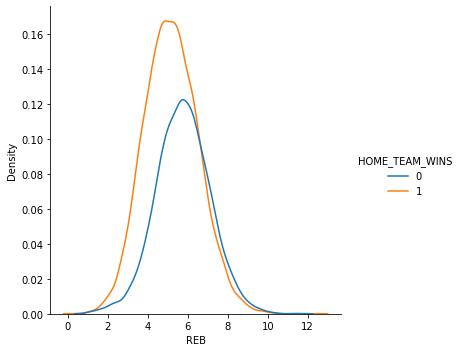

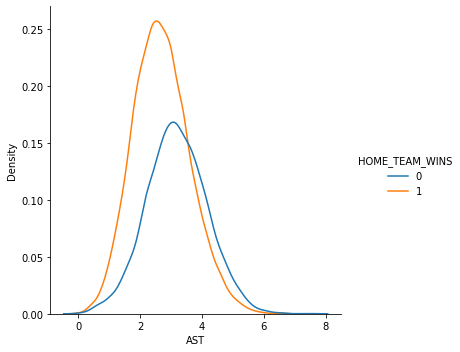

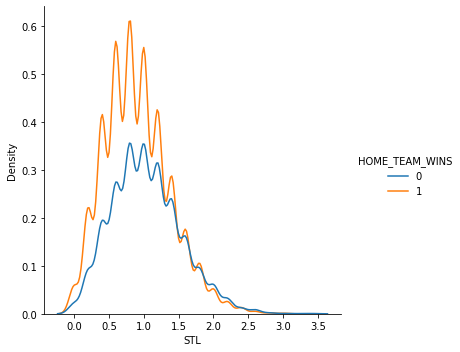

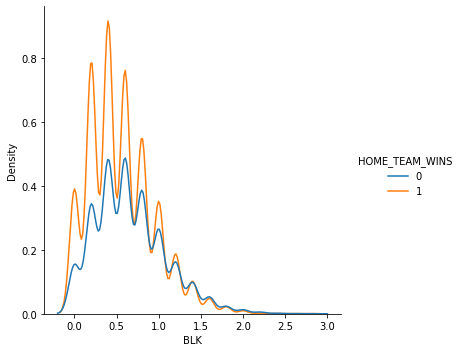

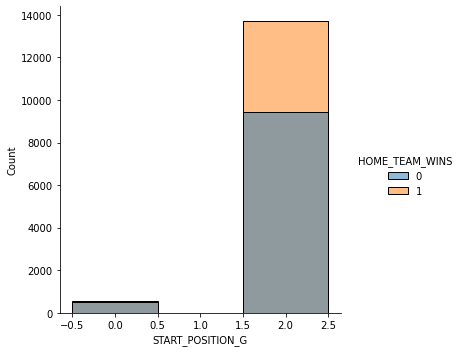

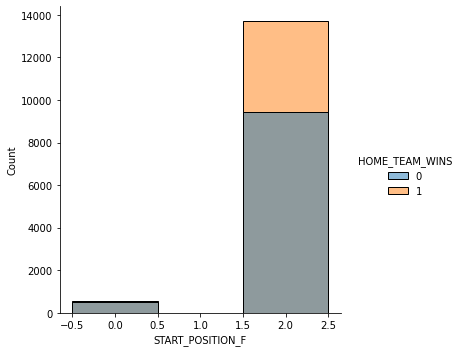

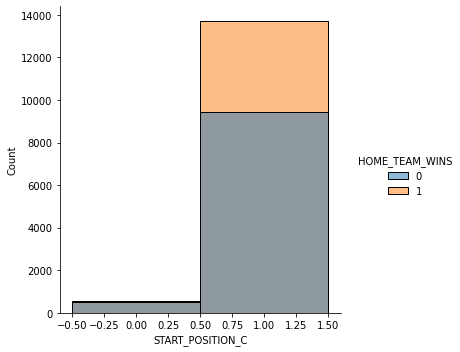

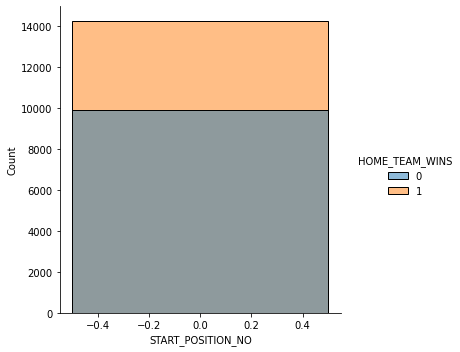

In [ ]:
""" Displaying the Comparison Graphs"""

sns.displot(df_result_explore,x='SEASON',hue='HOME_TEAM_WINS',discrete=True)
sns.displot(df_result_explore,x='PTS',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='FG_PCT', hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='FG3_PCT',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='FT_PCT',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='REB',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='AST',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='STL',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='BLK',hue='HOME_TEAM_WINS',kind='kde')
sns.displot(df_result_explore,x='START_POSITION_G',hue='HOME_TEAM_WINS',discrete=True)
sns.displot(df_result_explore,x='START_POSITION_F',hue='HOME_TEAM_WINS',discrete=True)
sns.displot(df_result_explore,x='START_POSITION_C',hue='HOME_TEAM_WINS',discrete=True)
sns.displot(df_result_explore,x='START_POSITION_NO',hue='HOME_TEAM_WINS',discrete=True)


# 3. Data Engineering
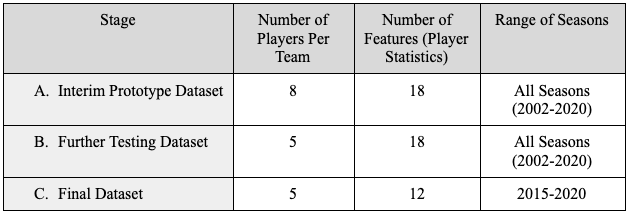


In [ ]:
""" Narrowing the Game Results from 2014 to 2020 """

#picking seasons from 2015 to 2019 for training and dev set. 2020 season will be test set
df_result = df_result[df_result['SEASON'] > 2014]
df_result = df_result[df_result['SEASON'] <= 2020] #2020 season included for streamlining preprocessing of all data together
df_result = df_result.sort_values(['GAME_ID'],ascending=(True))
print(df_result)

        GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  HOME_TEAM_WINS  SEASON
22776  11500001    1610612746       1610612743               1    2015
22774  11500002    1610612753       1610612766               0    2015
22775  11500003    1610612754       1610612740               0    2015
22773  11500004    1610612747       1610612762               0    2015
22772  11500005    1610612761       1610612746               1    2015
...         ...           ...              ...             ...     ...
727    41900403    1610612748       1610612747               1    2019
726    41900404    1610612748       1610612747               0    2019
725    41900405    1610612747       1610612748               0    2019
724    41900406    1610612748       1610612747               0    2019
807    51900111    1610612757       1610612763               1    2019

[7546 rows x 5 columns]


In [ ]:
""" Dropping Extraneous Columns from the Input Dataframe 'df' """

#dropping extraneous columns
df.drop(['PLAYER_ID','TEAM_ABBREVIATION','TEAM_CITY','PLAYER_NAME','COMMENT','FGM','FGA','FG3M','FG3A','FTM','FTA'], axis='columns',inplace=True)
display(df)

,GAME_ID,TEAM_ID,START_POSITION,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22000645,1610612754,F,41:45,0.455,0.455,0.000,0.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,15.0,8.0
1,22000645,1610612754,F,35:06,0.385,0.000,1.000,2.0,9.0,11.0,1.0,3.0,0.0,5.0,6.0,17.0,-2.0
2,22000645,1610612754,C,29:58,0.500,0.600,0.833,1.0,5.0,6.0,1.0,0.0,5.0,2.0,3.0,16.0,6.0
3,22000645,1610612754,G,34:42,0.278,0.333,1.000,0.0,3.0,3.0,3.0,1.0,0.0,0.0,1.0,13.0,1.0
4,22000645,1610612754,G,40:35,0.235,0.273,0.500,3.0,3.0,6.0,10.0,1.0,0.0,2.0,1.0,12.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602762,11200005,1610612743,NaN,19,0.444,0.500,0.857,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
602763,11200005,1610612743,NaN,23,0.636,0.000,1.000,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
602764,11200005,1610612743,NaN,15,0.429,0.000,0.000,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
602765,11200005,1610612743,NaN,19,1.000,0.000,0.000,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


In [ ]:
""" Keeping GAME_ID that are in the Output Dataframe 'df_result' """

#only keeping games from 2015 to 2020 to have the same games as df_result (match outcome dataset) 
df = df[df['GAME_ID'].isin(df_result['GAME_ID'])]

In [ ]:
""" OneHotEncoder for START_POSITION """

#label encoding
from sklearn.preprocessing import OneHotEncoder, normalize, MinMaxScaler

#filling NaN values of START_POSITION to 'NO'
df['START_POSITION']= df['START_POSITION'].fillna('NO')

encoded_features = []

#one hot encoding the start position for each player
feature='START_POSITION'
encoded_feat = OneHotEncoder().fit_transform(df['START_POSITION'].values.reshape(-1, 1)).toarray()
n = df['START_POSITION'].nunique()
cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
encoded_df = pd.DataFrame(encoded_feat, columns=cols)
encoded_df.index = df.index
encoded_features.append(encoded_df)

#adding encoded features to df
df = pd.concat([df, *encoded_features[:1]], axis=1)

#removing start posiiton from df as it has been hot encoded
df.drop(['START_POSITION'],axis='columns',inplace=True)

display(df)

,GAME_ID,TEAM_ID,MIN,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,START_POSITION_1,START_POSITION_2,START_POSITION_3,START_POSITION_4
0,22000645,1610612754,41:45,0.455,0.455,0.000,0.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,15.0,8.0,0.0,1.0,0.0,0.0
1,22000645,1610612754,35:06,0.385,0.000,1.000,2.0,9.0,11.0,1.0,3.0,0.0,5.0,6.0,17.0,-2.0,0.0,1.0,0.0,0.0
2,22000645,1610612754,29:58,0.500,0.600,0.833,1.0,5.0,6.0,1.0,0.0,5.0,2.0,3.0,16.0,6.0,1.0,0.0,0.0,0.0
3,22000645,1610612754,34:42,0.278,0.333,1.000,0.0,3.0,3.0,3.0,1.0,0.0,0.0,1.0,13.0,1.0,0.0,0.0,1.0,0.0
4,22000645,1610612754,40:35,0.235,0.273,0.500,3.0,3.0,6.0,10.0,1.0,0.0,2.0,1.0,12.0,6.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492934,11500001,1610612746,7:26,0.500,0.500,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
492935,11500001,1610612746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
492936,11500001,1610612746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
492937,11500001,1610612746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0


In [ ]:
""" Dropping Players with No Stats """

#dropped rows with no stats (based on "PLUS_MINUS")
#these are players who did not play the match
df.dropna(subset=["PLUS_MINUS"],inplace=True)


In [ ]:
""" Converting MIN to SEC and Dropping Players with 0 Sec Played"""

#changing min to sec
df['MIN'] = df['MIN'].apply(lambda x: int(str(x)[:str(x).index(':')])*60+int(str(x)[str(x).index(':')+1:]))
# dropping rows with 0 min played
df.drop(df[df["MIN"]==0].index,inplace=True)
#renaming the column "MIN" to "SEC"
df = df.rename(columns={'MIN':'SEC'})


In [ ]:
""" Creating a New Column 'PTS/SEC' """

#want to adjust the points scored by a player for the time played
#people who play for a short duration might have lesser points but greater scoring efficiency (vis a vis time)
#also helps us evaluate the impact of a player who might have played for a shorter duration but scored relatively more points 
df['PTS/SEC'] = df['PTS']/df['SEC'] #points per second
display(df)

,GAME_ID,TEAM_ID,SEC,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,START_POSITION_1,START_POSITION_2,START_POSITION_3,START_POSITION_4,PTS/SEC
0,22000645,1610612754,2505,0.455,0.455,0.000,0.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,15.0,8.0,0.0,1.0,0.0,0.0,0.005988
1,22000645,1610612754,2106,0.385,0.000,1.000,2.0,9.0,11.0,1.0,3.0,0.0,5.0,6.0,17.0,-2.0,0.0,1.0,0.0,0.0,0.008072
2,22000645,1610612754,1798,0.500,0.600,0.833,1.0,5.0,6.0,1.0,0.0,5.0,2.0,3.0,16.0,6.0,1.0,0.0,0.0,0.0,0.008899
3,22000645,1610612754,2082,0.278,0.333,1.000,0.0,3.0,3.0,3.0,1.0,0.0,0.0,1.0,13.0,1.0,0.0,0.0,1.0,0.0,0.006244
4,22000645,1610612754,2435,0.235,0.273,0.500,3.0,3.0,6.0,10.0,1.0,0.0,2.0,1.0,12.0,6.0,0.0,0.0,1.0,0.0,0.004928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492930,11500001,1610612746,1282,0.333,0.333,0.714,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,10.0,-10.0,0.0,0.0,0.0,1.0,0.007800
492931,11500001,1610612746,1453,0.385,0.000,0.600,2.0,6.0,8.0,2.0,0.0,0.0,2.0,3.0,13.0,-11.0,0.0,0.0,0.0,1.0,0.008947
492932,11500001,1610612746,767,0.333,0.250,0.000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0,-6.0,0.0,0.0,0.0,1.0,0.006519
492933,11500001,1610612746,275,0.000,0.000,1.000,2.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,-5.0,0.0,0.0,0.0,1.0,0.014545


In [ ]:
""" Normalizing Input Features """

# Normalization: 3 methods
# after several rounds of experimentation, we normalized the following columns: PTS/SEC, REB, AST, STL, BLK

# 1. Scaling values
# df['PTS/SEC'] = MinMaxScaler().fit_transform(np.array(df['PTS/SEC']).reshape(-1,1))
# df['REB'] = MinMaxScaler().fit_transform(np.array(df['REB']).reshape(-1,1))
# df['AST'] = MinMaxScaler().fit_transform(np.array(df['AST']).reshape(-1,1))
# df['STL'] = MinMaxScaler().fit_transform(np.array(df['STL']).reshape(-1,1))
# df['BLK'] = MinMaxScaler().fit_transform(np.array(df['BLK']).reshape(-1,1))


# 2. Dividing by mean
# df['PTS/SEC'] = (df['PTS/SEC']/df['PTS/SEC'].mean())
# df['REB'] = (df['REB']/df['REB'].mean())
# df['AST'] = (df['AST']/df['AST'].mean())
# df['STL'] = (df['STL']/df['STL'].mean())
# df['BLK'] = (df['BLK']/df['BLK'].mean())

# 3. Standardization
df['PTS/SEC'] = (df['PTS/SEC']-df['PTS/SEC'].mean())/df['PTS/SEC'].std()
df['REB'] = (df['REB']-df['REB'].mean())/df['REB'].std()
df['AST'] = (df['AST']-df['AST'].mean())/df['AST'].std()
df['STL'] = (df['STL']-df['STL'].mean())/df['STL'].std()
df['BLK'] = (df['BLK']-df['BLK'].mean())/df['BLK'].std()

Sorting by GAME_ID

In [ ]:
""" Sorting the Input and the Ouput Dataframes into the Same Orders """

#sorting players by their SEC in a descending order
df = df.sort_values(['GAME_ID','TEAM_ID','SEC'],ascending=(True,True,False))
#each row now represnts a player in a game
#data looks like
#game_n ->  team_1 ->  player_1
#game_n ->  team_1 ->  player_2
#                      ...
#                      ...
#                      ...
#game_n ->  team_2 ->  player_1
#game_n ->  team_2 ->  player_2
#                      ...
#                      ...
#                      ...
# team1 and team2 are decided by value of team id (greater team id -> team_1)
# player_n is decided by time played (player_1 plays for more time than player_2)

#sorting games in df_result by game id to match df
df_result = df_result.sort_values(['GAME_ID'],ascending=(True))
df.iloc[5:15]

,GAME_ID,TEAM_ID,SEC,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,START_POSITION_1,START_POSITION_2,START_POSITION_3,START_POSITION_4,PTS/SEC
492912,11500001,1610612743,1332,0.500,0.000,0.80,2.0,11.0,2.579501,-0.067760,-0.745147,-0.546905,3.0,0.0,12.0,9.0,0.0,0.0,0.0,1.0,0.397562
492905,11500001,1610612743,1148,0.143,0.000,0.00,1.0,5.0,0.551829,-0.880021,-0.745147,-0.546905,3.0,2.0,2.0,-14.0,1.0,0.0,0.0,0.0,-0.929705
492910,11500001,1610612743,1141,0.375,0.333,0.75,0.0,3.0,-0.317173,1.962892,-0.745147,-0.546905,1.0,3.0,10.0,8.0,0.0,0.0,0.0,1.0,0.352856
492906,11500001,1610612743,1138,0.500,1.000,0.00,0.0,0.0,-1.186175,-0.880021,-0.745147,-0.546905,1.0,3.0,6.0,-16.0,0.0,0.0,1.0,0.0,-0.284917
492904,11500001,1610612743,1110,0.000,0.000,0.00,0.0,5.0,0.262162,-0.473890,0.293537,0.666587,4.0,4.0,0.0,-8.0,0.0,1.0,0.0,0.0,-1.247905
492913,11500001,1610612743,541,0.000,0.000,0.00,0.0,0.0,-1.186175,-0.880021,-0.745147,-0.546905,0.0,1.0,0.0,-4.0,0.0,0.0,0.0,1.0,-1.247905
492924,11500001,1610612746,1587,0.857,0.000,0.60,1.0,11.0,2.289834,-0.880021,-0.745147,3.093572,2.0,1.0,15.0,19.0,1.0,0.0,0.0,0.0,0.478436
492923,11500001,1610612746,1579,0.357,0.000,1.00,0.0,5.0,0.262162,-0.067760,0.293537,0.666587,1.0,1.0,11.0,14.0,0.0,1.0,0.0,0.0,0.024492
492927,11500001,1610612746,1557,0.286,0.200,0.00,0.0,1.0,-0.896508,-0.067760,0.293537,-0.546905,2.0,2.0,5.0,0.0,0.0,0.0,0.0,1.0,-0.661371
492931,11500001,1610612746,1453,0.385,0.000,0.60,2.0,6.0,1.131164,-0.067760,-0.745147,-0.546905,2.0,3.0,13.0,-11.0,0.0,0.0,0.0,1.0,0.386237




> We want to make sure we have five players per team.



In [ ]:
""" Checking For Games with Any Team of Less Than 5 Players """

#count the min number of players for each team
games = df.pivot_table(index=['GAME_ID','TEAM_ID'],aggfunc='size')
games = games.reset_index()

#getting the teams with less than 5 players
games_with_min = games[games[0]<=4]
games_with_min = games_with_min.reset_index()
games_with_min

,index,GAME_ID,TEAM_ID,0


### Same order of GAME_ID's for the Input and Output Dataframe

In [ ]:
""" Checking Whether the Output and the Input Dataframes Have the Same GAME_ID """

#get rid of rows with game_id stored in games_with_min (ie games in which any team plays less than 5 players). Our model will take exactly 8 players as input
#df = df[~df['GAME_ID'].isin(games_with_min['GAME_ID'])]

#game_ids from df
df_game_ids = df['GAME_ID'].tolist()
df_game_ids = set(df_game_ids)

#game_ids from df_result
df_result_game_ids = df_result['GAME_ID'].tolist()
df_result_game_ids = set(df_result_game_ids)

print("# OF GAMES IN df:", len(df_game_ids))
print("# of GAMES IN df_result:", len(df_result_game_ids))

#difference in games between df and df_result
print("Games that are only in df_games_ids")
print(df_result[~df_result.isin(df_game_ids).iloc[:,0]])

print("Games that are only in df_result_games_ids")
print(df[~df.isin(df_result_game_ids).iloc[:,0]])


# OF GAMES IN df: 7497
# of GAMES IN df_result: 7497
Games that are only in df_games_ids
Empty DataFrame
Columns: [GAME_ID, HOME_TEAM_ID, VISITOR_TEAM_ID, HOME_TEAM_WINS, SEASON]
Index: []
Games that are only in df_result_games_ids
Empty DataFrame
Columns: [GAME_ID, TEAM_ID, SEC, FG_PCT, FG3_PCT, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TO, PF, PTS, PLUS_MINUS, START_POSITION_1, START_POSITION_2, START_POSITION_3, START_POSITION_4, PTS/SEC]
Index: []


In [ ]:
""" Dropping Extra GAME_ID's from the Output Dataframe """

#dropping rows with extra game_ids from df_result
extra_game_ids = df_result[~df_result.isin(df_game_ids).iloc[:,0]]
print("Number of Extra GAME_IDS:",len(extra_game_ids))
if len(extra_game_ids) != 0: 
  for i in extra_game_ids["GAME_ID"]:
    df_result.drop(df_result[df_result['GAME_ID']== i].index,inplace=True)


Number of Extra GAME_IDS: 0


In [ ]:
""" Checking on Duplicates of GAME_ID's from the Output Dataframe """

#the above cell shows that there are 7,546 rows, but we have 7,497 games
#the previous cell led to discovery of duplicate datas
game_ids = df_result.pivot_table(index=['GAME_ID'], aggfunc='size')

#removing duplicates from df_result
game_ids_duplicates = game_ids[game_ids>1]
#print (game_ids_duplicates) TO SHOW DUPLICATES?
df_result = df_result.drop_duplicates()
print(df_result)

        GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  HOME_TEAM_WINS  SEASON
22776  11500001    1610612746       1610612743               1    2015
22774  11500002    1610612753       1610612766               0    2015
22775  11500003    1610612754       1610612740               0    2015
22773  11500004    1610612747       1610612762               0    2015
22772  11500005    1610612761       1610612746               1    2015
...         ...           ...              ...             ...     ...
727    41900403    1610612748       1610612747               1    2019
726    41900404    1610612748       1610612747               0    2019
725    41900405    1610612747       1610612748               0    2019
724    41900406    1610612748       1610612747               0    2019
807    51900111    1610612757       1610612763               1    2019

[7497 rows x 5 columns]


In [ ]:
""" Checking If There are Any Extra GAME_ID in both the Input and the Output Dataframes """

#rechecking whether the two dfs have the same game_ids
#game_ids from df
df_game_ids = df['GAME_ID'].tolist()
df_game_ids = set(df_game_ids)

#game_ids from df_result
df_result_game_ids = df_result['GAME_ID'].tolist()
df_result_game_ids = set(df_result_game_ids)
print(df_result_game_ids)

print("Games that are only in df_games_ids")
print(df_result[~df_result.isin(df_game_ids).iloc[:,0]])

print("Games that are only in df_result_games_ids")
print(df[~df.isin(df_result_game_ids).iloc[:,0]])

#GOOD TO GO

{11600001, 11600002, 11600004, 11600005, 11600006, 11600007, 11600009, 11600011, 11600012, 11600013, 11600014, 11600015, 11600016, 11600017, 11600018, 11600019, 11600021, 11600022, 11600023, 11600024, 11600025, 11600026, 11600027, 11600028, 11600029, 11600030, 11600031, 11600032, 11600033, 11600034, 11600035, 11600036, 11600037, 11600038, 11600039, 11600040, 11600041, 11600042, 11600044, 11600045, 11600046, 11600047, 11600048, 11600049, 11600050, 11600051, 11600052, 11600053, 11600054, 11600055, 11600056, 11600057, 11600058, 11600059, 11600061, 11600062, 11600063, 11600064, 11600065, 11600066, 11600067, 11600068, 11600069, 11600070, 11600071, 11600072, 11600073, 11600074, 11600075, 11600076, 11600077, 11600078, 11600079, 11600080, 11600081, 11600082, 11600083, 11600084, 11600085, 11600086, 11600087, 11600088, 11600089, 11600090, 11600091, 11600092, 11600093, 11600094, 11600095, 11600096, 11600097, 11600098, 11600099, 11600100, 11600101, 11600102, 11700001, 11700002, 11700003, 11700004,

In [ ]:
""" Restructuring the Output Dataframe to Show W/L for the First Team """

# restructuring data to show if the team with the greater team id won (as df has each game sorted by game id as well as team id)
# df_result2 = df_result.copy()
for i in range(len(df_result)):
  # column1 --> team1(home) , column2 --> team2(away)
  # "TEAM_1_WINS" indicates W/L for the team with a greater ID
  if (df_result.iloc[i,2]<df_result.iloc[i,1]): # team1 has a greater team ID, then we have to switch up the game results
    if (df_result.iloc[i,3]==0): #if the column3 equals to 0, it means that the smaller team ID loses (i.e. team 1 loses).
      df_result.iloc[i,3]=1
    else:
      df_result.iloc[i,3]=0
df_result = df_result.rename(columns={'HOME_TEAM_WINS':'TEAM_1_WINS'})
df_result

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,TEAM_1_WINS,SEASON
22776,11500001,1610612746,1610612743,0,2015
22774,11500002,1610612753,1610612766,0,2015
22775,11500003,1610612754,1610612740,1,2015
22773,11500004,1610612747,1610612762,0,2015
22772,11500005,1610612761,1610612746,0,2015
...,...,...,...,...,...
727,41900403,1610612748,1610612747,0,2019
726,41900404,1610612748,1610612747,1,2019
725,41900405,1610612747,1610612748,0,2019
724,41900406,1610612748,1610612747,1,2019


In [ ]:
""" Checking the Ranges of the Input Features """

df.max() - df.min()

GAME_ID             4.040011e+07
TEAM_ID             2.900000e+01
SEC                 3.897000e+03
FG_PCT              1.000000e+00
FG3_PCT             1.000000e+00
FT_PCT              1.000000e+00
OREB                1.300000e+01
DREB                2.300000e+01
REB                 8.690023e+00
AST                 1.015326e+01
STL                 1.038684e+01
BLK                 1.334841e+01
TO                  1.200000e+01
PF                  6.000000e+00
PTS                 7.000000e+01
PLUS_MINUS          1.080000e+02
START_POSITION_1    1.000000e+00
START_POSITION_2    1.000000e+00
START_POSITION_3    1.000000e+00
START_POSITION_4    1.000000e+00
PTS/SEC             1.826469e+02
dtype: float64

### Splitting the Dataset into the Train+Dev Set and the Test Set

In [ ]:
""" Splitting the Ouput Dataframe into the Train+Dev Set and the Test Set """

# Games played in 2020 are for the test set
df_result_test = df_result[df_result['SEASON'] == 2020]
# Dropping rows that are in the test set from the train+dev set
df_result = df_result[~df_result['GAME_ID'].isin(df_result_test['GAME_ID'])]


In [ ]:
""" Splitting the Input Dataframe into the Train+Dev Set and the Test Set """

# Games included in the output test set are in the input test set
df_test = df[df['GAME_ID'].isin(df_result_test['GAME_ID'])]
# Games that are not in the test set are for train+dev set
df = df[~df['GAME_ID'].isin(df_result_test['GAME_ID'])]


In [ ]:
""" Confirming on the Shapes for the Train+Dev Set and the Test Set """

print("Train+Dev Set")
print(df.shape)
print(df_result.shape)

print("Test Set")
print(df_test.shape)
print(df_result_test.shape)


Train+Dev Set
(147189, 21)
(6822, 5)
Test Set
(14928, 21)
(675, 5)


### Preparing the outputs to be fed into the models
Outputs (1 indicates win and 0 indicates loss)
 - For one game:
1. An array of 1 by 2, e.g. [1, 0] 
2. An array of 1 by 1, e.g. [1]

In [ ]:
""" 1. Train+Dev Set: Preparing the Output (1 BY 2 For One Game) for the Models """
import numpy as np

df_result_final = [] #local var
for i in df_result['TEAM_1_WINS']:
  df_result_help = [i]
  if i==1:
    df_result_help.append(0)
  else:
    df_result_help.append(1)
  # Appending an array with 2 values into 'df_result_final'
  df_result_final.append(df_result_help)

# Converting the array into the numpy array
match_results_2d = np.array(df_result_final)

# match_results_2d for the train+dev set

In [ ]:
""" 1. Test Set: Preparing the Output (Dimension 1 BY 2 For One Game) for the Models """

df_result_final = [] #local var
for i in df_result_test['TEAM_1_WINS']:
  df_result_help = [i]
  if i==1:
    df_result_help.append(0)
  else:
    df_result_help.append(1)
  # Appending an array with 2 values into 'df_result_final'
  df_result_final.append(df_result_help)

# Converting the array into the numpy array
match_results_test_2d = np.array(df_result_final)

# match_results_test_2d for the test set

In [ ]:
""" 2. Both Sets: Preparing the Output (Dimension 1 BY 1 For One Game) for the Models """

# converting df_result and df_result_test to numpy
match_results = df_result['TEAM_1_WINS'].to_numpy()
match_results_test = df_result_test['TEAM_1_WINS'].to_numpy()

### Preparing the inputs to be fed into the models


In [ ]:
""" Both Sets: Dropping Some Features """

df.drop(['SEC','PLUS_MINUS','OREB','DREB','TO','PF','PTS'],axis='columns',inplace=True)
df_test.drop(['SEC','PLUS_MINUS','OREB','DREB','TO','PF','PTS'],axis='columns',inplace=True)

df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147189 entries, 492907 to 20934
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   GAME_ID           147189 non-null  int64  
 1   TEAM_ID           147189 non-null  int64  
 2   FG_PCT            147189 non-null  float64
 3   FG3_PCT           147189 non-null  float64
 4   FT_PCT            147189 non-null  float64
 5   REB               147189 non-null  float64
 6   AST               147189 non-null  float64
 7   STL               147189 non-null  float64
 8   BLK               147189 non-null  float64
 9   START_POSITION_1  147189 non-null  float64
 10  START_POSITION_2  147189 non-null  float64
 11  START_POSITION_3  147189 non-null  float64
 12  START_POSITION_4  147189 non-null  float64
 13  PTS/SEC           147189 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 16.8 MB


,GAME_ID,TEAM_ID,FG_PCT,FG3_PCT,FT_PCT,REB,AST,STL,BLK,START_POSITION_1,START_POSITION_2,START_POSITION_3,START_POSITION_4,PTS/SEC
492907,11500001,1610612743,0.278,0.429,0.500,-0.606841,0.338371,0.293537,-0.546905,0.0,0.0,1.0,0.0,0.053396
492909,11500001,1610612743,0.500,0.000,1.000,-0.896508,-0.473890,3.409588,-0.546905,0.0,0.0,0.0,1.0,-0.094567
492908,11500001,1610612743,0.700,0.000,1.000,2.000166,-0.880021,-0.745147,-0.546905,0.0,0.0,0.0,1.0,0.674693
492903,11500001,1610612743,0.417,0.333,0.000,1.131164,-0.067760,1.332220,-0.546905,0.0,1.0,0.0,0.0,0.205869
492911,11500001,1610612743,0.750,0.000,0.667,1.131164,-0.880021,0.293537,0.666587,0.0,0.0,0.0,1.0,0.602353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20932,51900111,1610612763,0.727,0.800,0.000,-0.027506,0.338371,-0.745147,1.880079,0.0,0.0,0.0,1.0,1.225309
20928,51900111,1610612763,0.500,0.500,1.000,-0.317173,-0.880021,-0.745147,0.666587,0.0,1.0,0.0,0.0,-0.338568
20933,51900111,1610612763,0.333,0.000,0.500,0.262162,-0.473890,-0.745147,-0.546905,0.0,0.0,0.0,1.0,-0.848823
20935,51900111,1610612763,0.250,1.000,0.000,-0.027506,-0.473890,1.332220,-0.546905,0.0,0.0,0.0,1.0,-0.613715


In [ ]:
""" Train+Dev Set: Preparing the Input for the Models """

#converting pandas df to numpy array for final input
match_stats = np.empty(0)
for i in df_result['GAME_ID']:
    df_ps = df[df['GAME_ID'] == i]            #A list of player stats for every match for both teams
    #only considering top 5 players by time played for balanced input
    df_ps_team1 = df_ps[df_ps['TEAM_ID'] == df_ps['TEAM_ID'].unique()[0]]
    df_ps_team1 = df_ps_team1[0:5]
    df_ps_team2 = df_ps[df_ps['TEAM_ID'] == df_ps['TEAM_ID'].unique()[1]]
    df_ps_team2 = df_ps_team2[0:5]

    # dropping GAME_ID and TEAM_ID 
    df_ps_team1.drop(['GAME_ID','TEAM_ID'],axis='columns',inplace=True)
    df_ps_team2.drop(['GAME_ID','TEAM_ID'],axis='columns',inplace=True)

    df_ps_team1 = df_ps_team1.to_numpy().flatten()
    df_ps_team2 = df_ps_team2.to_numpy().flatten()

    # df_ps_teams is in 2(2 teams) by 60(12 features for one player)
    df_ps_teams = np.array([df_ps_team1, df_ps_team2])
    
    # appending df_ps_teams into the final input numpy array
    if (match_stats.size == 0):
        match_stats = np.array([df_ps_teams])
    else:
        match_stats = np.append(match_stats, np.array([df_ps_teams]), axis=0)
    
print(match_stats.shape)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(6822, 2, 60)


In [ ]:
""" Test Set: Preparing the Input for the Models """

#converting pandas df_test to numpy array for final input

match_stats_test = np.empty(0)
for i in df_result_test["GAME_ID"]:
    df_ps = df_test[df_test['GAME_ID'] == i]            #A list of player stats for every match for both teams
    #only considering top 5 players by time played for balanced input
    df_ps_team1 = df_ps[df_ps['TEAM_ID'] == df_ps['TEAM_ID'].unique()[0]]
    df_ps_team1 = df_ps_team1[0:5]
    df_ps_team2 = df_ps[df_ps['TEAM_ID'] == df_ps['TEAM_ID'].unique()[1]]
    df_ps_team2 = df_ps_team2[0:5]

    # dropping GAME_ID and TEAM_ID 
    df_ps_team1.drop(['GAME_ID','TEAM_ID'],axis='columns',inplace=True)
    df_ps_team2.drop(['GAME_ID','TEAM_ID'],axis='columns',inplace=True)

    df_ps_team1 = df_ps_team1.to_numpy().flatten()
    df_ps_team2 = df_ps_team2.to_numpy().flatten()

    # df_ps_teams is in 2(2 teams) by 60(12 features for one player)
    df_ps_teams = np.array([df_ps_team1, df_ps_team2])
    
    # appending df_ps_teams into the final input numpy array
    if (match_stats_test.size == 0):
        match_stats_test = np.array([df_ps_teams])
    else:
        match_stats_test = np.append(match_stats_test, np.array([df_ps_teams]), axis=0)

print(match_stats_test.shape)

(675, 2, 60)


# 4. Model Training and Testing

In [ ]:
""" Splitting Datasets for Training and Testing """

from sklearn.model_selection import train_test_split

# match_results_2d represents one game in a 1 by 2 array (for neural network)
X_train_nn, X_dev_nn, y_train_nn, y_dev_nn = train_test_split(match_stats, match_results_2d, shuffle = True, test_size=0.2, random_state=42)
# match_results represents one game in a 1 by 1 array (for scikit classifiers)
X_train, X_dev, y_train, y_dev = train_test_split(match_stats, match_results, shuffle = True, test_size=0.2, random_state=42)

In [ ]:
""" Checking the Shapes """

print(X_train_nn.shape)
print(y_train_nn.shape)
print(X_dev_nn.shape)
print(y_dev_nn.shape)

(5457, 2, 60)
(5457, 2)
(1365, 2, 60)
(1365, 2)


In [ ]:
""" Reshaping the Inputs from 3D to 2D """

#reshaping X_train and X_test
X_train = X_train.reshape(5457,120)
print(X_train.shape)
X_dev = X_dev.reshape(1365, 120)
print(X_dev.shape)

(5457, 120)
(1365, 120)


In [ ]:
""" Checking the Shapes for the Test Set """

print(match_stats_test.shape)
print(match_results_test_2d.shape)
print(match_results_test.shape)

(675, 2, 60)
(675, 2)
(675,)


### Logistic Regression

In [ ]:
""" Training the LR Model """

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# preparing the model
lr = LogisticRegression(solver='lbfgs', max_iter=10000)
# fitting the training datasets into the model
lr.fit(X_train,y_train)
# predicting with the dev dataset
Y_pred_lr = lr.predict(X_dev)
# calculating the accuracy
score_lr = round(accuracy_score(Y_pred_lr,y_dev)*100,2)

print("Dev Accuracy: "+str(score_lr)+" %")


Dev Accuracy: 79.41 %


In [ ]:
""" Testing the trained LR Model """

# testing with the test dataset
Y_pred_lr_test = lr.predict(match_stats_test.reshape(675, 120))
score_lr = round(accuracy_score(Y_pred_lr_test,match_results_test)*100,2)

print("Test Accuracy: "+str(score_lr)+" %")

Test Accuracy: 79.56 %


### SVM Model

In [ ]:
""" Training the SVM Model """

from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_dev)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Dev Accuracy:",metrics.accuracy_score(y_dev, y_pred))

Dev Accuracy: 0.7904761904761904


In [ ]:
""" Testing the trained SVM Model """

y_pred = clf.predict(match_stats_test.reshape(675,120))
print("Test Accuracy:",metrics.accuracy_score(match_results_test, y_pred))

Test Accuracy: 0.7866666666666666


### XGBoost Model

In [ ]:
""" Training the XGBoost Model """
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
print("Dev accuracy:", clf.score(X_dev, y_dev))

Dev accuracy: 0.7750915750915751


In [ ]:
""" Testing the trained XGBoost Model """

print("Test accuracy:", clf.score(match_stats_test.reshape(675,120), match_results_test))

Test accuracy: 0.76


### Neural Network

In [ ]:
""" Training the Neural Network Model """

import tensorflow as tf
from tensorflow import keras
with tf.device('/device:GPU:0'):
  model = keras.Sequential([
      keras.layers.Input(shape=(2,60)),
      keras.layers.Dense(60, activation=tf.nn.relu),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(30, activation=tf.nn.relu),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(15, activation=tf.nn.relu),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation=tf.nn.relu, name='output')
  ])

  model.summary()

  model.compile(optimizer='adam',
                loss=keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

  model.fit(X_train_nn, y_train_nn, epochs=30, batch_size=200)

  test_loss, test_acc = model.evaluate(X_dev_nn, y_dev_nn)
print('Dev accuracy:', test_acc)
#model.get_layer(name='output')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2, 60)             3660      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 60)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2, 30)             1830      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 30)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2, 15)             465       
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 15)             0         
_________________________________________________________________
output (Dense)               (None, 2, 1)             

In [ ]:
""" Testing the Trained Neural Network Model """

test_loss, test_acc = model.evaluate(match_stats_test, match_results_test_2d, batch_size=1)
print('Test accuracy:', test_acc)

675/675 [==============================] - 1s 1ms/step - loss: 0.2081 - accuracy: 0.6674
Test accuracy: 0.6674073934555054


### Comparing the Accuracies
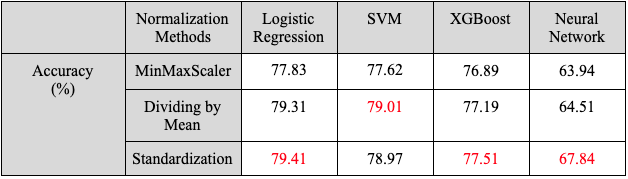
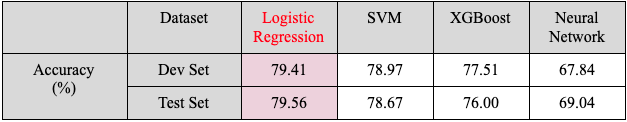

### Confusion Matrix for the Best Model 

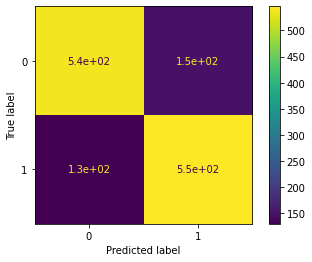

Confusion Matrix : 
 [[538 151]
 [130 546]]
Test accuracy =  0.7941391941391941


In [ ]:
""" Confusion Matrix for the LR Model """

import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, 
                           accuracy_score,plot_confusion_matrix)
predictions = list(map(round, Y_pred_lr))
# confusion matrix
cm = confusion_matrix(y_dev, predictions)
disp = plot_confusion_matrix(lr,X_dev, y_dev)
plt.show()
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_dev, predictions))

# 5. Exporting the Model

In [ ]:
""" Exporting the Model """

import pickle

pkl_filename = "/basketballPredictor.pkl"
model = lr
# pickle.dump(lr, open(data_dir+filename, 'wb'))
with open(data_dir+pkl_filename, 'wb') as file:
    pickle.dump(model, file)
